# NCI Data Access: Python NetCDF Landsat8

**The following will go through how to:** <br \>
   1. Access netCDF data locally from /g/data 
   2. Access published netCDF data through NCI's THREDDS Data Server (using OPeNDAP)
   3. Extract/view data
   4. Save data subset to new file


### If working from Raijin or the VDI (Virtual Desktop Infrastructure), load the required modules

```
$ module load python/2.7.5 
$ module load python/2.7.5-matplotlib

```

### Import python libraries

There are several Python libraries available to work with netCDF and HDF file formats. This tutorial will use `netCDF4` but others, such as `h5py`, `cdms2`, and `gdal` can also be used. For more information on these other libraries, please see the main tutorial page. 

**Note:** Python's netCDF4 library has to be installed locally by user on Raijin and the VDI

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt 
%matplotlib inline

## Open/read file
**Note:** This does not yet load/extract any data, just opens the file.

### The 'Dataset' function is used to open a file with Python's netCDF4 library. 
For local files, this will be the filepath (i.e., /g/data...) while for remote access, this will be the OPeNDAP data URL. For instructions on how to find the OPeNDAP URL, please see: [THREDDS Data Access](https://nbviewer.jupyter.org/github/kdruken/Notebooks/blob/master/THREDDS_DataAccess.ipynb)

#### 1. Accessing data locally (/g/data) 

In [2]:
path = '/g/data2/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_-10_-28_2013.nc'

#### 2. Accessing data remotely (OPeNDAP)

In [3]:
url = 'http://dapds00.nci.org.au/thredds/dodsC/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_-10_-28_2013.nc'

#### 3. Either the 'path' or the 'url' can be used now to open the file

In [4]:
f = Dataset(path, 'r')

In [6]:
# OR using the URL

f = Dataset(url, 'r')

#### After opening the file with the OPeNDAP address, the file can be handled in the same manner as a local file. 

## Browse information about the file

### File dimensions

In [7]:
for item in f.dimensions:
    print f.dimensions[item].name, f.dimensions[item].size

maxStrlen64 64
time 61
x 4000
y 4000


### File variables

In [8]:
vars = f.variables.keys()
for item in vars:
    print 'Variable: \t', item
    print 'Dimensions: \t', f[item].dimensions
    print 'Shape:    \t', f[item].shape, '\n'

Variable: 	y
Dimensions: 	(u'y',)
Shape:    	(4000,) 

Variable: 	x
Dimensions: 	(u'x',)
Shape:    	(4000,) 

Variable: 	time
Dimensions: 	(u'time',)
Shape:    	(61,) 

Variable: 	crs
Dimensions: 	()
Shape:    	() 

Variable: 	extra_metadata
Dimensions: 	(u'time', u'maxStrlen64')
Shape:    	(61, 64) 

Variable: 	band_6
Dimensions: 	(u'time', u'y', u'x')
Shape:    	(61, 4000, 4000) 

Variable: 	band_7
Dimensions: 	(u'time', u'y', u'x')
Shape:    	(61, 4000, 4000) 

Variable: 	band_4
Dimensions: 	(u'time', u'y', u'x')
Shape:    	(61, 4000, 4000) 

Variable: 	band_5
Dimensions: 	(u'time', u'y', u'x')
Shape:    	(61, 4000, 4000) 

Variable: 	band_2
Dimensions: 	(u'time', u'y', u'x')
Shape:    	(61, 4000, 4000) 

Variable: 	band_3
Dimensions: 	(u'time', u'y', u'x')
Shape:    	(61, 4000, 4000) 

Variable: 	band_1
Dimensions: 	(u'time', u'y', u'x')
Shape:    	(61, 4000, 4000) 



## Extracting data (using index values)
A nice feature of netCDF/HDF file formats is that you can extract subsets without having to read the entire file (or variable). The example below demonstrates the simplest subsetting example by directly specifying the subset indices. 

In [9]:
# Read variables (but not yet extract)
band2 = f['band_2']
y = f['y']
x = f['x']
t = f['time']

In [10]:
# Subset indices
x1, x2 = 1000,3999
y1, y2 = 0,3000
t1 = 9

In [11]:
%%time

# Extract
band2_subset = band2[t1, y1:y2, x1:x2]
y_subset = y[y1:y2]
x_subset = x[x1:x2]

CPU times: user 869 ms, sys: 117 ms, total: 986 ms
Wall time: 1.77 s


## Plot data

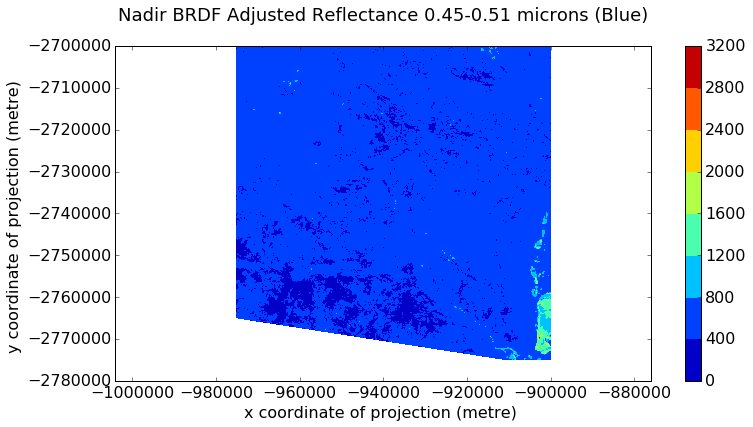

In [12]:
# Set figure size
plt.figure(figsize=(12,6))

# Plot data subset with equal axes and colorbar
plt.contourf(x_subset, y_subset, band2_subset)
plt.axis('equal')
cbar = plt.colorbar()

# Add figure title and labels
# We can make use of the defined variable attributes to do this
plt.title(band2.long_name+'\n', fontsize=18)
plt.xlabel(x.long_name+' ('+x.units+') ', fontsize=16)
plt.ylabel(y.long_name+' ('+y.units+') ', fontsize=16)

# Adjust tick mark size
cbar.ax.tick_params(labelsize=16) 
plt.tick_params(labelsize=16)


## Plot subset as RGB image
For more info on common band combinations: http://landsat.usgs.gov/L8_band_combos.php

#### Read in bands
**Note**: Bands must be clipped (value of 6000 was chosen in this case) and scaled to values between (0, 255) to plot as RGB image.

In [13]:
import numpy as np

In [14]:
band4_subset = f['band_4'][t1, y1:y2, x1:x2]
band6_subset = f['band_6'][t1, y1:y2, x1:x2]
band7_subset = f['band_7'][t1, y1:y2, x1:x2]

In [15]:
b4 = band4_subset.clip(0, 6000) / 6000. * 255
b6 = band6_subset.clip(0, 6000) / 6000. * 255
b7 = band7_subset.clip(0, 6000) / 6000. * 255

#### Combine the bands of interest into numpy NxNx3 dimensional array
**Note**: The data type must be converted to 'uint8' to plot as image

In [16]:
rgb = np.stack((b7, b6, b4), axis=2).astype('uint8')

print "New array shape: {0}, dtype: {1}".format(rgb.shape, rgb.dtype)

New array shape: (3000, 2999, 3), dtype: uint8


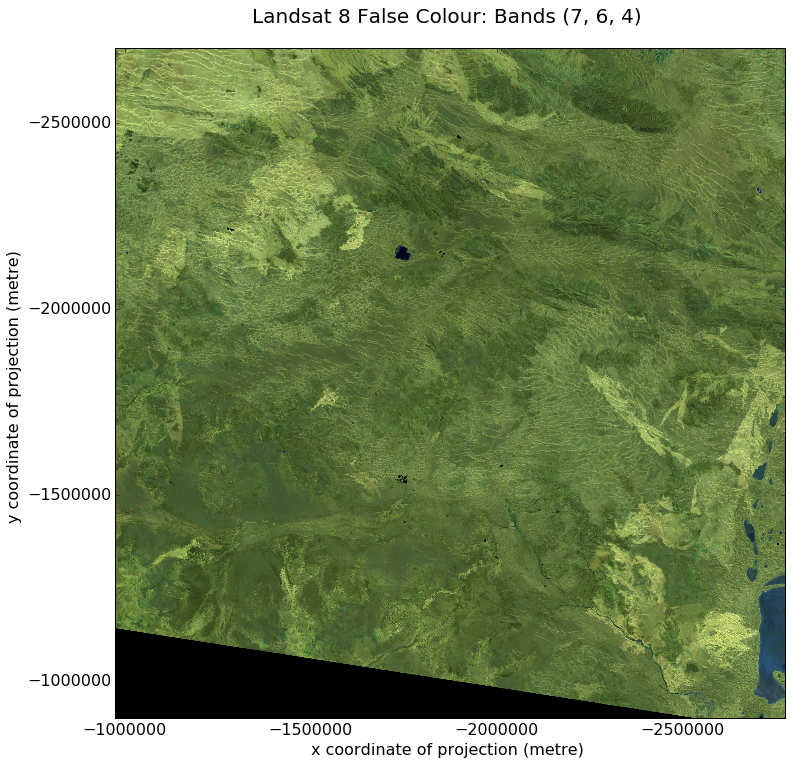

In [17]:
# Set figure size
plt.figure(figsize=(12,12))

# Plot image
plt.imshow(rgb, extent=[x_subset[0], y_subset[-1], x_subset[-1], y_subset[0]])

# Add figure title and labels
# We can make use of the defined variable attributes to do this
plt.title('Landsat 8 False Colour: Bands (7, 6, 4) \n', fontsize=20)
plt.xlabel(x.long_name+' ('+x.units+') ', fontsize=16)
plt.ylabel(y.long_name+' ('+y.units+') ', fontsize=16)


# Adjust tick mark size
plt.tick_params(labelsize=16)

#### Close file

In [21]:
f.close()